In [1]:
import gc
import logging
logging.disable(logging.WARNING)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp
import tensorflow_addons as tfa

mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

2.6.3


In [2]:
# Load data
df = pd.read_parquet('E:/train_low_mem.parquet')
df.drop(['row_id'], inplace=True, axis=1)
y = df.pop("target")

investment_id = df.pop("investment_id")
investment_ids = list(investment_id.unique())
investment_id_lookup_layer = IntegerLookup(oov_token=-1, output_mode='int')
investment_id_lookup_layer.adapt(np.array(investment_ids))
vocab = investment_id_lookup_layer.get_vocabulary(include_special_tokens=True)
vocab_size = investment_id_lookup_layer.vocabulary_size()
print(max(investment_ids))
print(vocab_size)

3773
3580


In [3]:
def preprocess(x, y):
    # flatten and normalize
    return x, tf.math.sign(y) * tf.math.log1p(tf.math.log1p(tf.math.abs(y)))

def post_process(y):
    y = list(map(np.ndarray.item, list(y)))
    y = tf.math.sign(y) * (tf.math.expm1(tf.math.expm1(tf.math.sign(y) * y)))
    return y.numpy()

def make_dataset(feature, investment_id, y, batch_size=8192, mode='train'):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train": ds = ds.shuffle(8192, seed=69)  # only shuffle when training
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


# Pearson correlation coefficient loss and metrics
def pearson_corr(y_true, y_pred, axis=-1):
    return tfp.stats.correlation(tf.squeeze(y_pred), tf.squeeze(y_true), sample_axis=axis, event_axis=None)

def pearson_corr_loss(y_true, y_pred, axis=-1):
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    corr_loss = 1 - pearson_corr(y_true, y_pred, axis=axis)
    return corr_loss + mse

In [4]:
# Model
def build_model():
    global opt
    investment_id_inputs = Input((1, ), name='inv_id_in', dtype=tf.uint8)
    features_inputs = Input((300, ), name='feature_in', dtype=tf.float16)

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = Embedding(vocab_size, 64, input_length=1)(investment_id_x)
    investment_id_x = Reshape((-1, ))(investment_id_x)
    investment_id_x = Dense(64)(investment_id_x)
    investment_id_x = tfa.activations.mish(investment_id_x)
    investment_id_x = LayerNormalization()(investment_id_x)
    investment_id_x = Dropout(0.4)(investment_id_x)
    investment_id_x = Dense(64)(investment_id_x)
    investment_id_x = tfa.activations.mish(investment_id_x)
    investment_id_x = LayerNormalization()(investment_id_x)
    investment_id_x = Dropout(0.4)(investment_id_x)
    investment_id_x = Dense(64)(investment_id_x)
    investment_id_x = tfa.activations.mish(investment_id_x)
    investment_id_x = LayerNormalization()(investment_id_x)
    investment_id_x = Dropout(0.4)(investment_id_x)

    feature_x = GaussianNoise(0.05)(features_inputs)
    feature_x = Dense(256)(feature_x)
    feature_x = tfa.activations.mish(feature_x)
    feature_x = LayerNormalization()(feature_x)
    feature_x = Dropout(0.4)(feature_x)
    feature_x = Dense(256)(feature_x)
    feature_x = tfa.activations.mish(feature_x)
    feature_x = LayerNormalization()(feature_x)
    feature_x = Dropout(0.4)(feature_x)
    feature_x = Dense(256)(feature_x)
    feature_x = tfa.activations.mish(feature_x)
    feature_x = LayerNormalization()(feature_x)
    feature_x = Dropout(0.4)(feature_x)

    x = Concatenate(axis=1)([investment_id_x, feature_x])
    x = Dense(512)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128)(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activity_regularizer='l2')(x)
    x = tfa.activations.mish(x)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    xOut = Dense(1, name='output')(x)

    model = Model(inputs=[investment_id_inputs, features_inputs], outputs=[xOut])
    opt = tfa.optimizers.RectifiedAdam()
    opt = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
    # opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=5e-4)
    model.compile(loss=pearson_corr_loss, optimizer=opt, metrics=[pearson_corr, 'mse'])
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inv_id_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           inv_id_in[0][0]                  
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 64)        229120      integer_lookup[0][0]             
__________________________________________________________________________________________________
feature_in (InputLayer)         [(None, 300)]        0                                            
______________________________________________________________________________________________

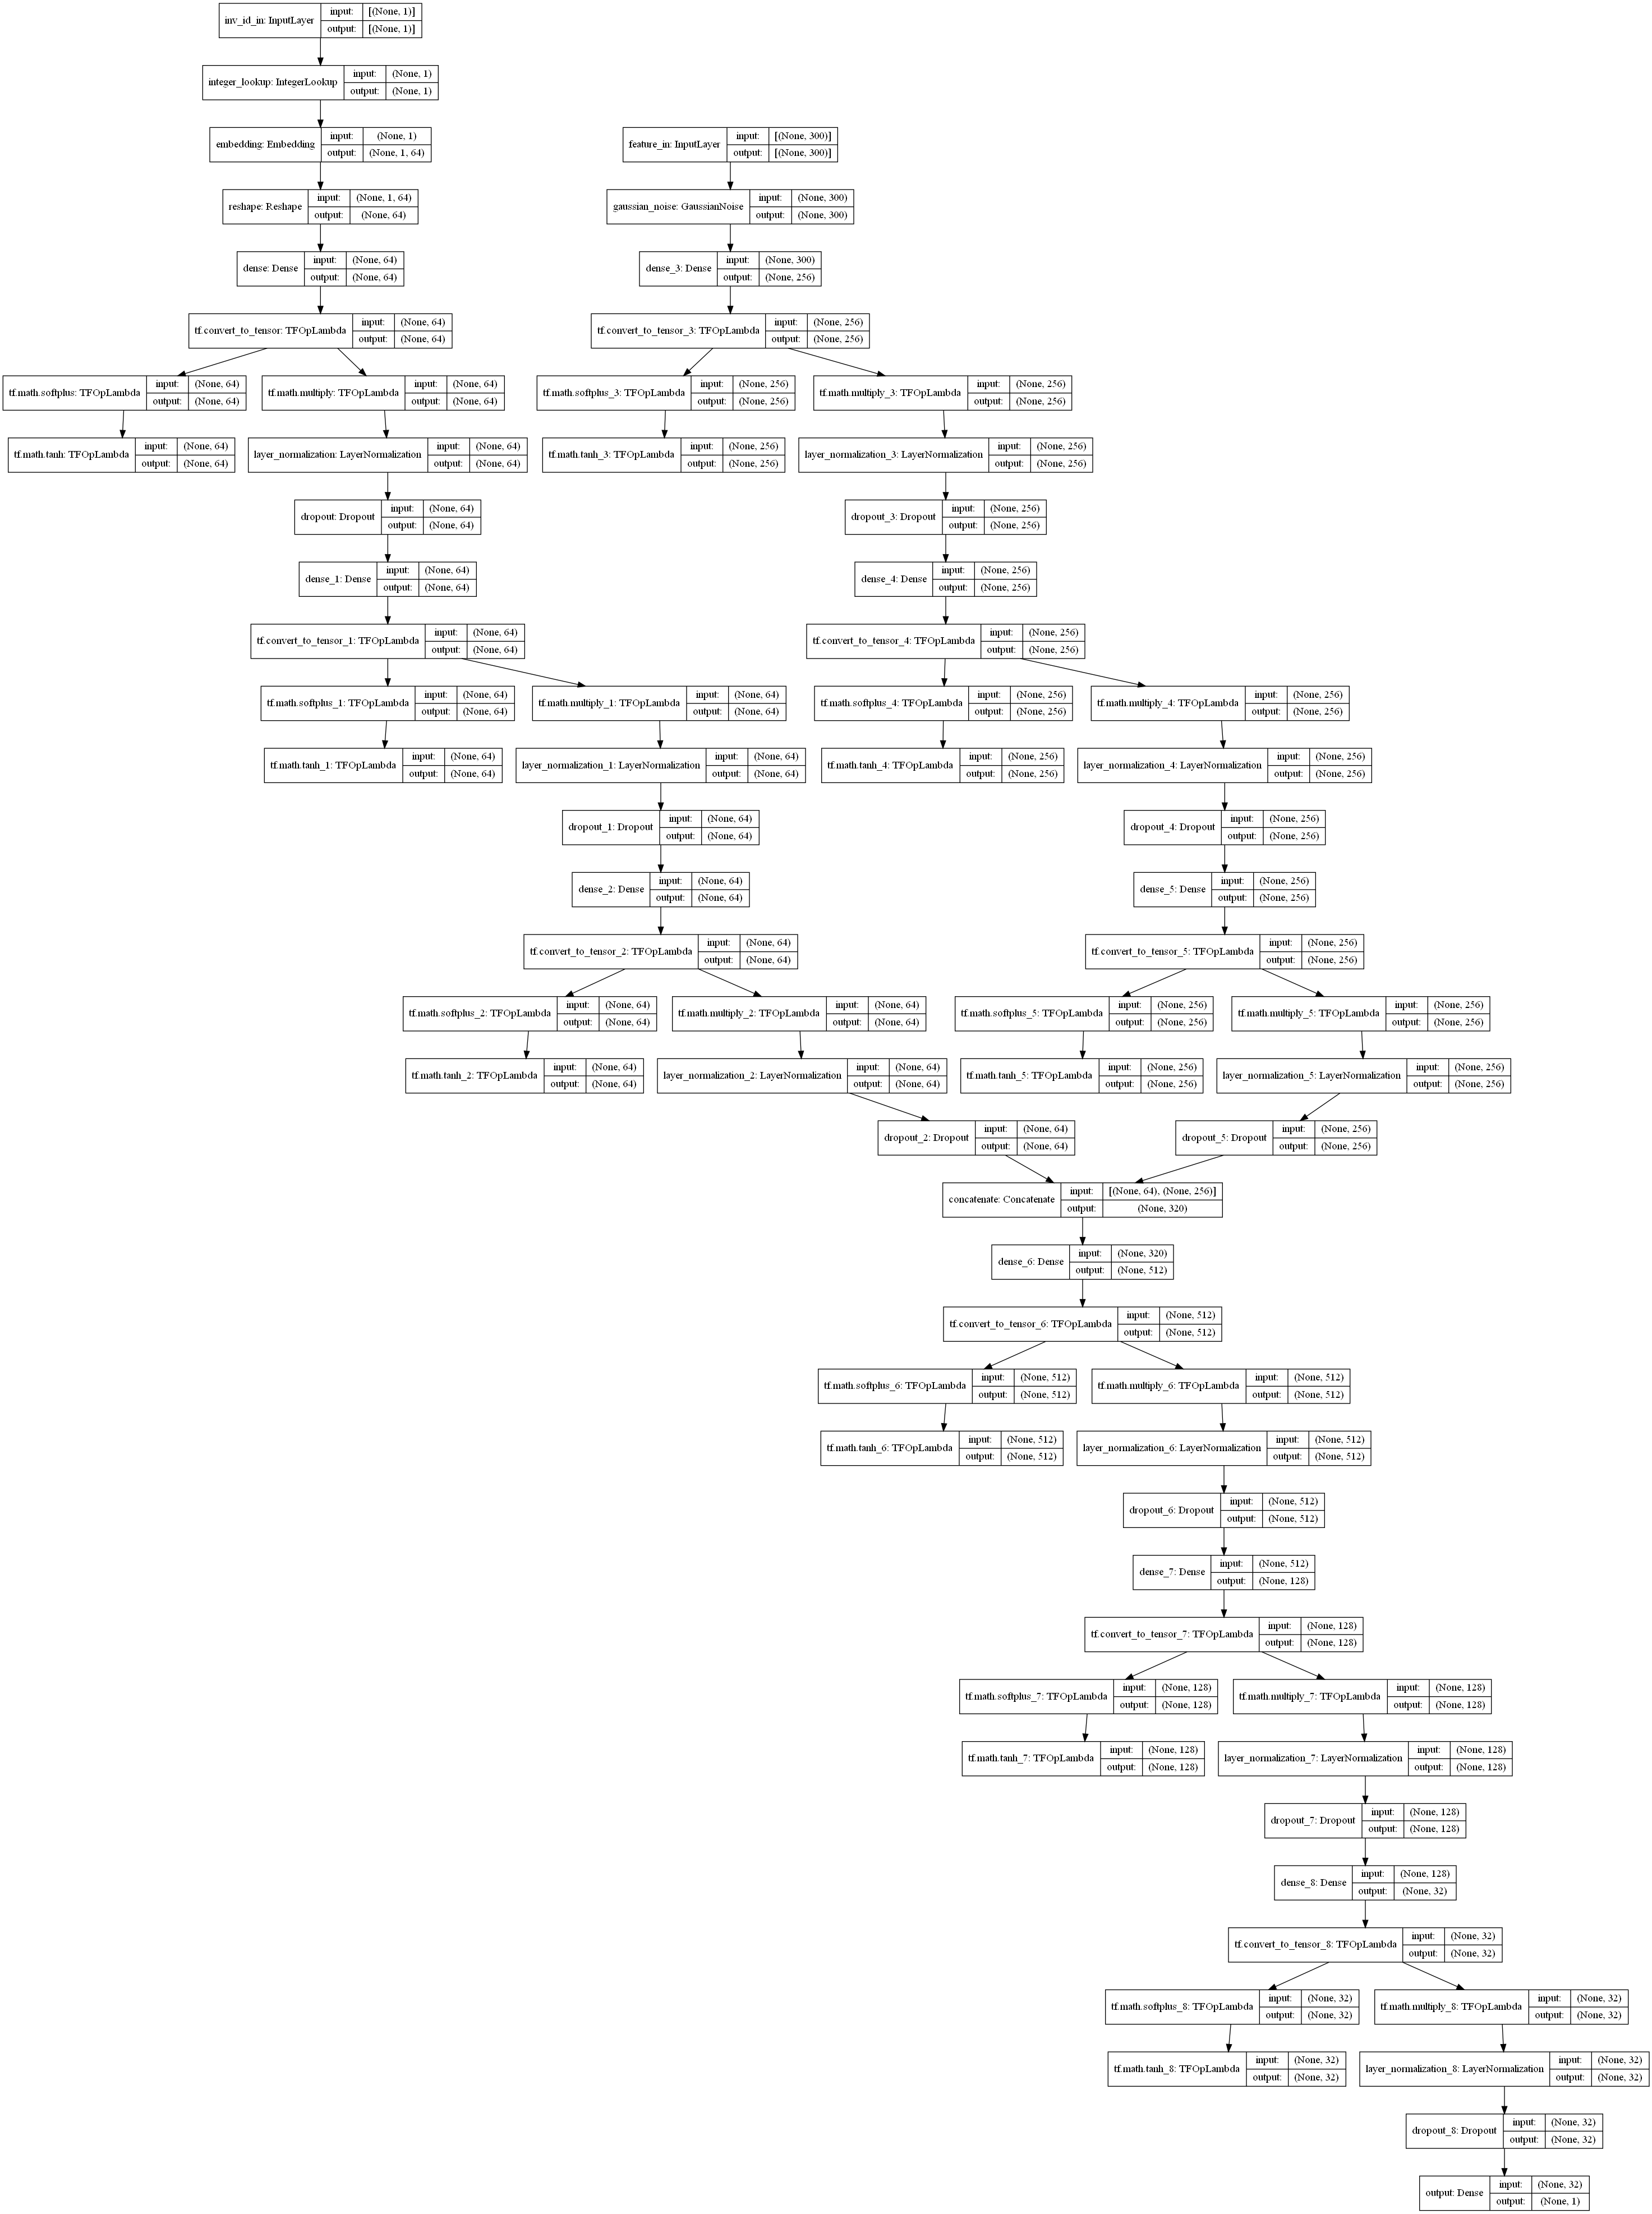

In [5]:
model = build_model()
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

In [7]:
from typing import Tuple
import numpy as np

class GroupTimeSeriesSplit:
    """
    Custom class to create a Group Time Series Split. We ensure
    that the time id values that are in the testing data are not a part
    of the training data & the splits are temporal
    """
    def __init__(self, n_folds: int, holdout_size: int, groups: str) -> None:
        self.n_folds = n_folds
        self.holdout_size = holdout_size
        self.groups = groups

    def split(self, X) -> Tuple[np.array, np.array]:
        # Take the group column and get the unique values
        unique_time_ids = np.unique(self.groups.values)

        # Split the time ids into the length of the holdout size
        # and reverse so we work backwards in time. Also, makes
        # it easier to get the correct time_id values per
        # split
        array_split_time_ids = np.array_split(
            unique_time_ids, len(unique_time_ids) // self.holdout_size
        )[::-1]

        # Get the first n_folds values
        array_split_time_ids = array_split_time_ids[:self.n_folds]

        for time_ids in array_split_time_ids:
            # Get test index - time id values that are in the time_ids
            test_condition = X['time_id'].isin(time_ids)
            test_index = X.loc[test_condition].index

            # Get train index - The train index will be the time
            # id values right up until the minimum value in the test
            # data - we can also add a gap to this step by
            # time id < (min - gap)
            train_condition = X['time_id'] < (np.min(time_ids))
            train_index = X.loc[train_condition].index

            yield train_index, test_index

In [6]:
import scipy
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=69)
# group_time_series_split = GroupTimeSeriesSplit(n_folds=6, holdout_size=200, groups=df['time_id'])
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(df, investment_id)):
    print(f'Model {index}')
    X_train, X_val = df.iloc[train_indices].loc[:, df.columns != 'time_id'], df.iloc[valid_indices].loc[:, df.columns != 'time_id']
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = build_model()
    callbacks = [tf.keras.callbacks.ModelCheckpoint(f"model_{index}", monitor='val_mse', save_best_only=True, mode='min'),
                 tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_mse', verbose=1, restore_best_weights=True, mode='min'),
                 tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=6, verbose=1, monitor='val_mse', mode='min')]
    history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=callbacks)
    models.append(load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss, 'Addons>Lookahead': opt}))

    pearson_score = scipy.stats.pearsonr(post_process(model.predict(valid_ds)), y_val.values)[0]
    print('Pearson:', pearson_score)
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    del model
    gc.collect()

C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=6.
  warnings.warn(


Model 0
Epoch 1/50
320/320 [==============================] - 25s 33ms/step - loss: inf - pearson_corr: 0.0043 - mse: 1.7261 - val_loss: inf - val_pearson_corr: 0.0285 - val_mse: 0.8409
Epoch 2/50
320/320 [==============================] - 11s 34ms/step - loss: inf - pearson_corr: 0.0134 - mse: 0.9657 - val_loss: 1.7922 - val_pearson_corr: 0.0843 - val_mse: 0.8509
Epoch 3/50
320/320 [==============================] - 5s 17ms/step - loss: 1.8699 - pearson_corr: 0.0536 - mse: 0.8773 - val_loss: 1.7916 - val_pearson_corr: 0.0829 - val_mse: 0.8609
Epoch 4/50
320/320 [==============================] - 5s 16ms/step - loss: 1.7925 - pearson_corr: 0.0822 - mse: 0.8537 - val_loss: 1.7586 - val_pearson_corr: 0.0950 - val_mse: 0.8448
Epoch 5/50
320/320 [==============================] - 5s 16ms/step - loss: 1.7571 - pearson_corr: 0.1007 - mse: 0.8443 - val_loss: 1.7450 - val_pearson_corr: 0.1037 - val_mse: 0.8428
Epoch 6/50
320/320 [==============================] - 5s 16ms/step - loss: 1.7388 - 

In [ ]:
import scipy
X_train, y_train = df.loc[:, df.columns != 'time_id'], y
investment_id_train = investment_id
# train_ds = make_dataset(X_train, investment_id_train, y_train)
model = build_model()
callbacks = [tf.keras.callbacks.ModelCheckpoint(f"model_comb", monitor='val_mse', save_best_only=True, mode='min'),
             tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_mse', verbose=1, restore_best_weights=True, mode='min'),
             tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=6, verbose=1, monitor='val_mse', mode='min'),
             tf.keras.callbacks.TerminateOnNaN()]
history = model.fit({'inv_id_in': investment_id_train, 'feature_in': X_train}, y_train, batch_size=8192, epochs=100, validation_split=0.2, callbacks=callbacks)

In [7]:
from ubiquantEmulator import TimeSeriesAPI

def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

def post_process(y):
    y = list(map(np.ndarray.item, list(y)))
    y = tf.math.sign(y) * (tf.math.expm1(tf.math.expm1(tf.math.sign(y) * y)))
    return y.numpy()

def make_test_dataset(feature, investment_id, batch_size=8192):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(post_process(y_pred))
    return np.mean(y_preds, axis=0)  # ensemble

models = [load_model(f"model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(6)]
# models = [load_model(f"model_comb", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss})]
# models += [load_model(f"1/model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(6)]
# test = pd.read_parquet('E:/train_low_mem.parquet')
# time_ids = df['time_id'].unique()
# test = test.loc[test['time_id'].isin(time_ids)]  # take last 200 time id rows from df
test = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
iter_test = TimeSeriesAPI(test)
for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    iter_test.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {iter_test.score()}')

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
       row_id    target
18211     8_1  0.040405
18212     8_2  0.061523
18213     8_6  0.022247
18214     8_7 -0.002993
18215     8_8  0.007641
...       ...       ...
19995  8_2961 -0.123291
19996  8_2963  0.000089
19997  8_2964 -0.274414
19998  8_2965  0.016006
19999  8_2966 -0.109924

[1789 rows x 2 columns]
Pearson: (       row_id    target  prediction
0         0_1 -0.300875    0.174072
1         0_2 -0.231040   -0.043945
2         0_6  0.568807    0.047913
3         0_7 -1.064780   -0.117310
4         0_8 -0.531940    0.010551
...       ...       ...         ...
19995  8_2961  2.395875   -0.123291
19996  8_2963  0.293830    0.000089
19997  8_2964  0.295464   -0.274414
19998  8_2965 -0.722136    0.016006
19999  8_2966 -0.268326   -0.109924

[20000 rows x 3 columns], 0.18041558535599808)


In [9]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {scipy.stats.pearsonr(sample_prediction_df["target"].values, test_df["target"].values)[0]}')

ModuleNotFoundError: No module named 'ubiquant'